In [1]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [30]:
pickle.dump(links,open('links_stats_EWMA_transf.pickle','wb'))

In [27]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

def get_link_data(src, dst, act, date='2017-08-01', span=1):
    es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
    DATE = date  # yyyy-mm-dd
    DELTA = span
    # Generate the indexes to scan
    dt.datetime.strptime(DATE,'%Y-%m-%d')
    index_list = []
    for i in range(-1, DELTA+1):
        index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                          + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
    #indexes = ','.join(index_list)
    indexes = 'fts_*'
    #print (index_list)
    period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
    period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
    transfer_query = {
        "size": 0,
        "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
        'query':{
            "bool" : {
                "must" : [
                    {"term" : { "dst" : src }},
                    {"term" : { "src" : dst }},
                    {"term" : { "activity" : act }},
                    {"range" : {"transferred_at" : {  "gte": period_start } }},
                    {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                    ]
            }
        }

    }
    scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
    epoch = dt.datetime(1970,1,1)
    st = time.time()
    count = 0
    data = []
    for res in scroll:
        r = res['_source']
        #if not count%1000000 : print (count)
        r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
        count += 1
    #print('Reading took',time.time() - st,'seconds.')
    data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
    data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
    data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
    data['T_TIME'] = data['ENDED'] - data['SUBMITTED']
    print('%d records retrieved for link %s --> %s (%s).' % (len(data), src, dst, act))
    return data
def holt_winters_second_order_ewma( x, span, beta ):
    N = x.size
    alpha = 2.0 / ( 1 + span )
    s = np.zeros(( N, ))
    b = np.zeros(( N, ))
    s[0] = x[0]
    for i in range( 1, N ):
        s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
        b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
    return s[-1],b[-1]
def hwsoewma_forcast(s0, b0, beta, span):
    '''Forcast span values after s0'''
    s = [s0]
    b = [b0]
    queue_limit_time = 7*24*60*60  # 7 days in sec.
    for i in range(1,span):
        s.append(min((s[i-1] + i*b[i-1]),queue_limit_time))
        b.append(beta*(s[i] - s[i-1])+(1-beta)*b[i-1])
    return (s,b)

def calculate_ewma(window=12, beta=0.1):
    preds = []
    for t in data.index:
        history = cut[cut.index < t]
        history = history[history.index > history.index.max() - dt.timedelta(hours=windows)]
        if len(history) > 3:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s,b = hwsoewma_forcast(s0, b0, beta, 1)
            preds.append(max(s[0],-1))
        else:
            preds.append(-1)
    return preds


def make_prediction(data, window, every, beta=0.0001):
    cut1 = data.set_index(pd.to_datetime(data.SUBMITTED, unit='s'))
    cut1 = cut1.sort_index()
    cut2 = data.set_index(pd.to_datetime(data.ENDED, unit='s'))
    cut2 = cut2.sort_index()
    current = cut1.index.min()
    preds = []
    while current < cut1.index.max():
        s = cut1[cut1.index < current + dt.timedelta(minutes=every)]
        s = s[s.index > current]
        fspan = len(s)
        if fspan == 0:
            current = current + dt.timedelta(minutes=every)
            continue
        history = cut2[cut2.index < current]
        #history = history.set_index(pd.to_datetime(history.ENDED.values,unit='s'))
        #history = history.sort_index()
        history = history.loc[history.index[-window:]]
        if len(history) > 3:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s1,b = hwsoewma_forcast(s0, b0, beta, len(s))
            preds.extend(s1)
        else:
            preds.extend([-1]*len(s))
        current = current + dt.timedelta(minutes=every)
    return cut1.SUBMITTED.values[:len(preds)],np.array(preds), cut1.Q_TIME.values[:len(preds)]

In [ ]:
data = get_link_data('BNL-ATLAS', 'CERN-PROD', 'Data Consolidation','2017-08-01', 30)
x,y,y_real = make_prediction(data, 12, 5, 0.000001)

30167 records retrieved for link CERN-PROD --> BNL-ATLAS (Data Consolidation).


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:77: RuntimeWarning: overflow encountered in double_scalars
/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:78: RuntimeWarning: invalid value encountered in double_scalars
/home/ivukotic/anaconda3/lib/python3.5/site-packages/sklearn/metrics/regression.py:463: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


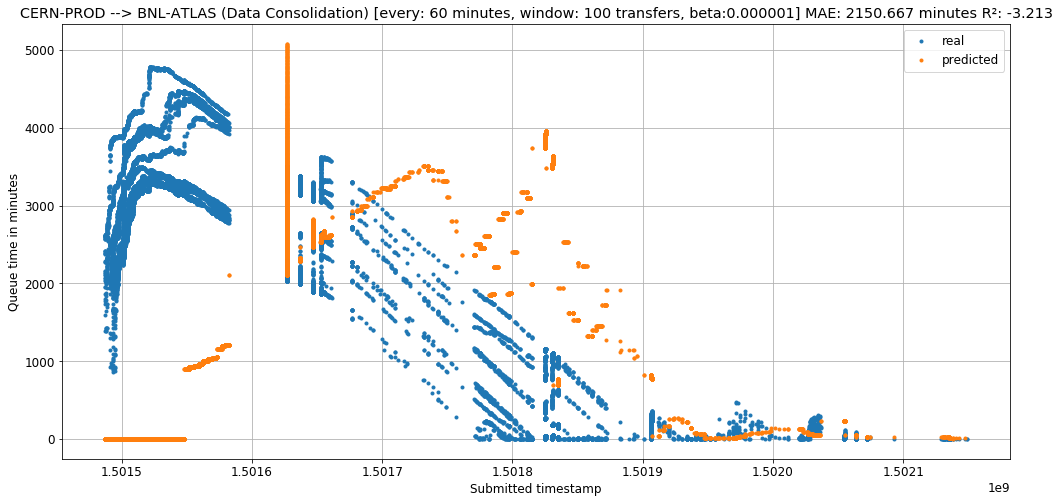

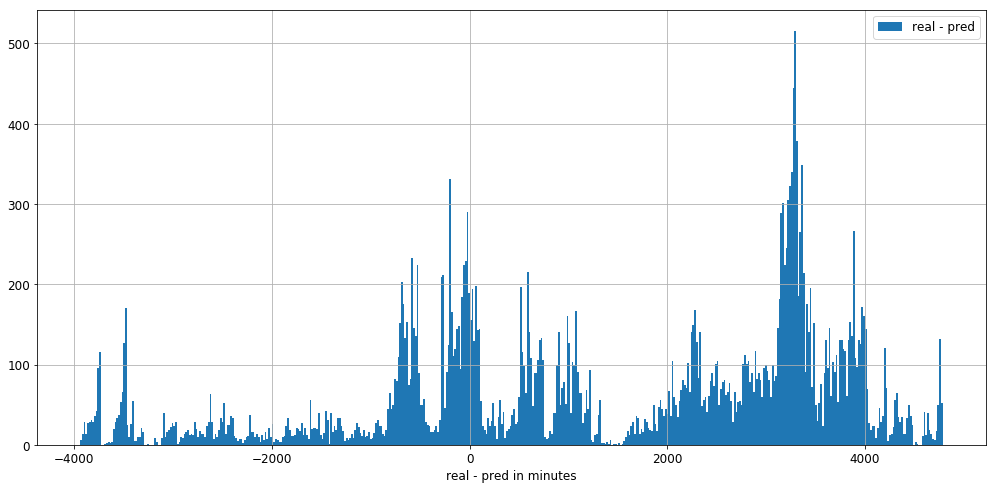

1477 records retrieved for link BNL-ATLAS --> BNL-ATLAS (Data Consolidation).


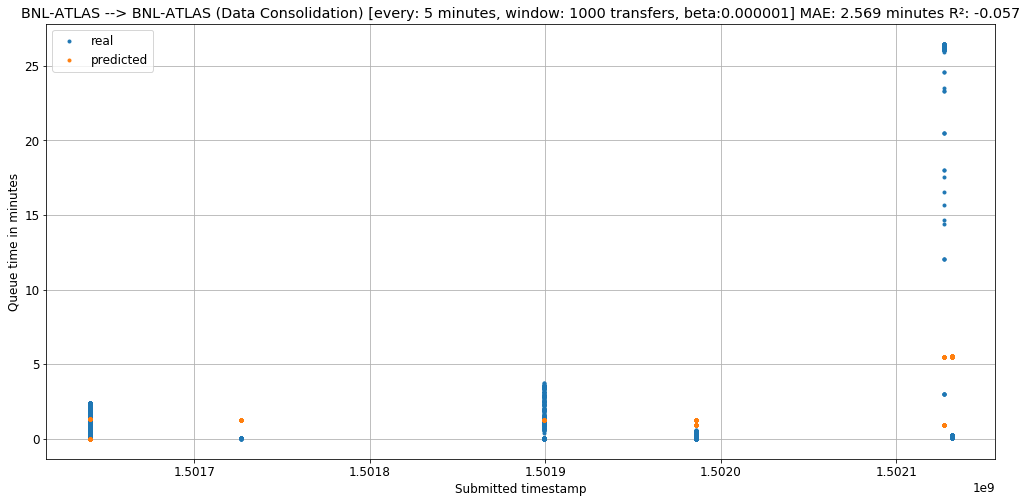

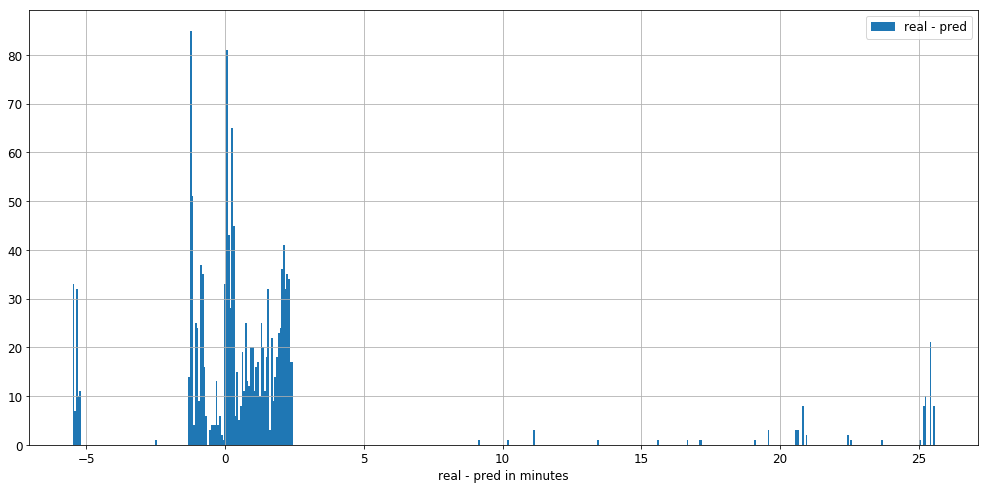

1306 records retrieved for link NDGF-T1 --> BNL-ATLAS (Data Consolidation).


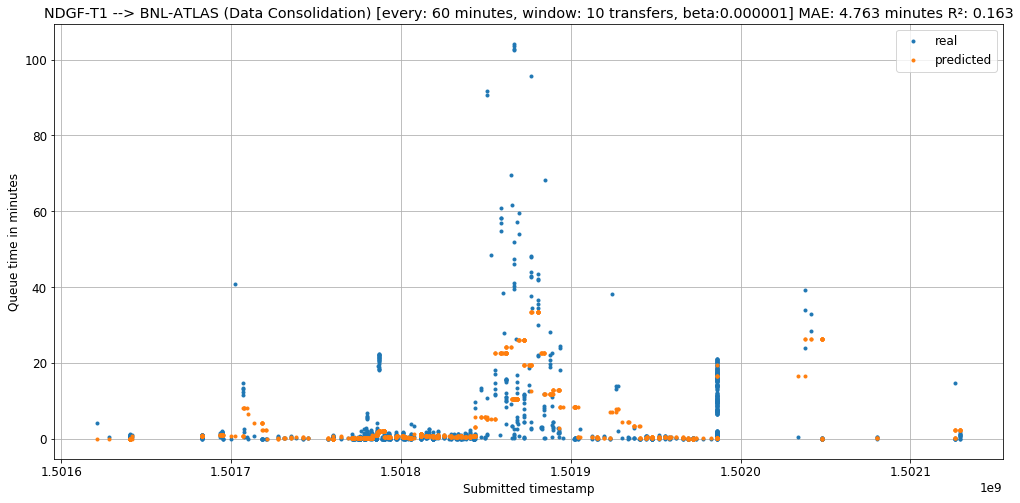

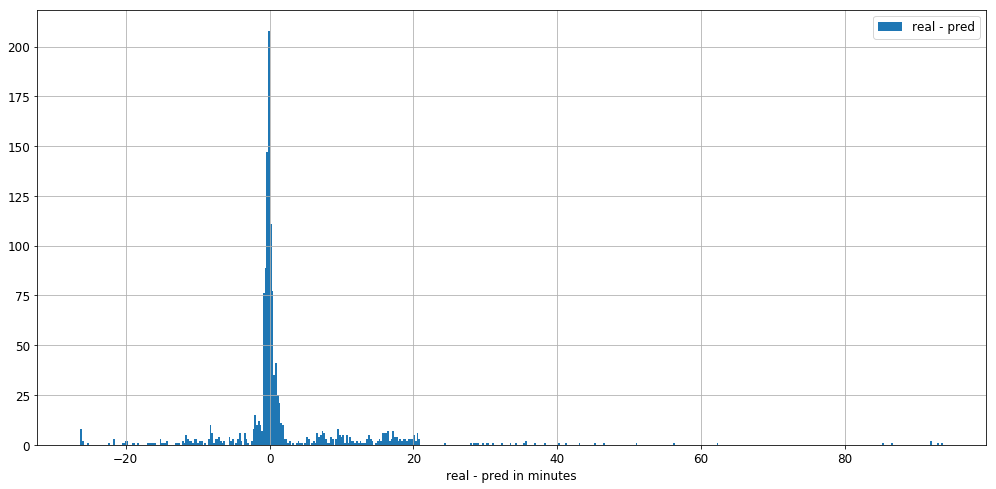

10462 records retrieved for link IN2P3-CC --> BNL-ATLAS (Data Consolidation).


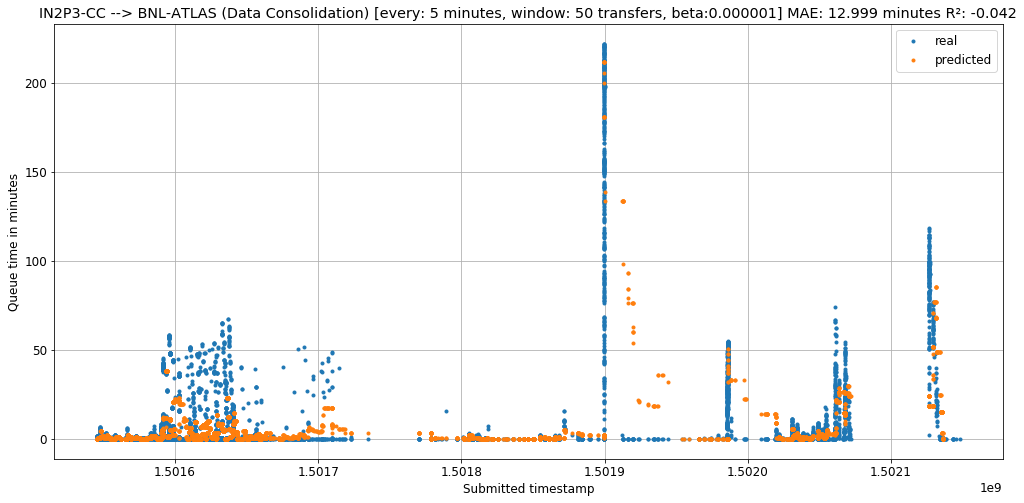

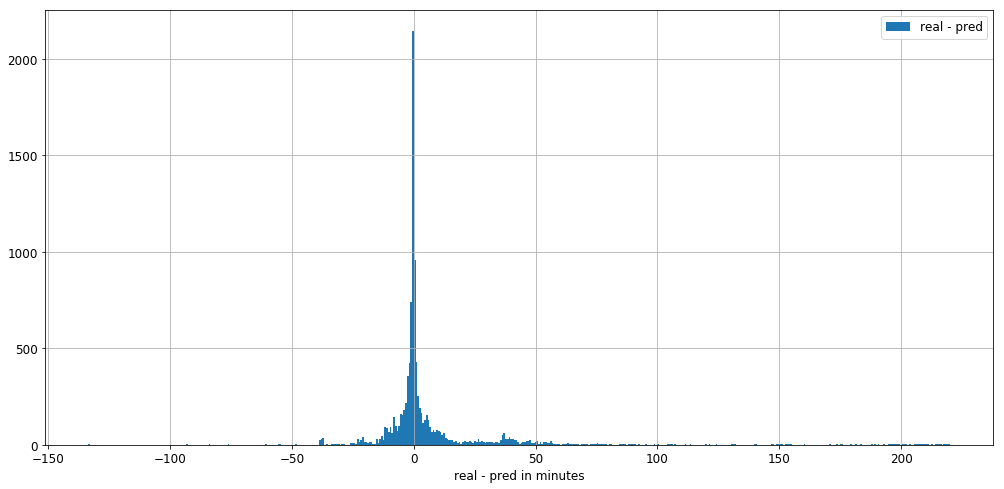

0 records retrieved for link WT2 --> BNL-ATLAS (Data Consolidation).
No enough data for link WT2 --> BNL-ATLAS (Data Consolidation)
179 records retrieved for link CERN-PROD --> INFN-ROMA1 (Data Consolidation).


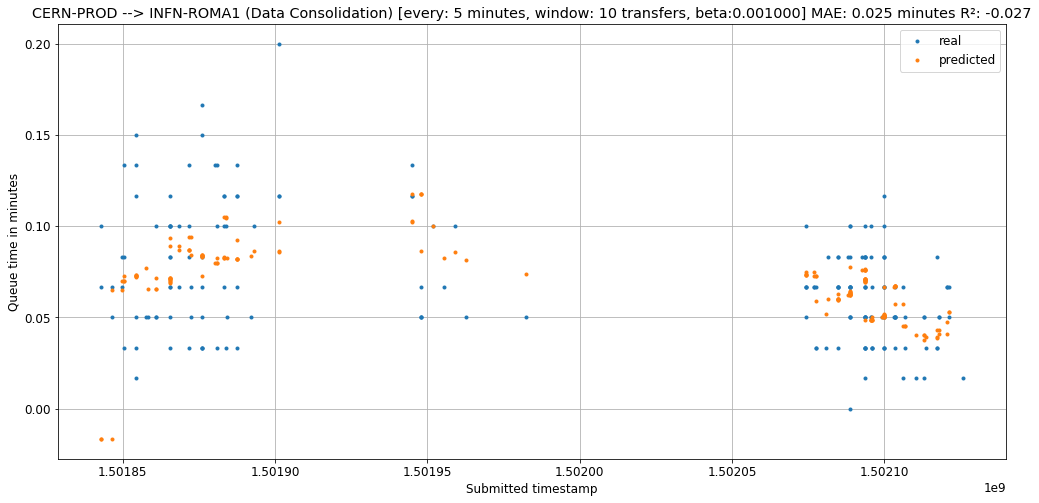

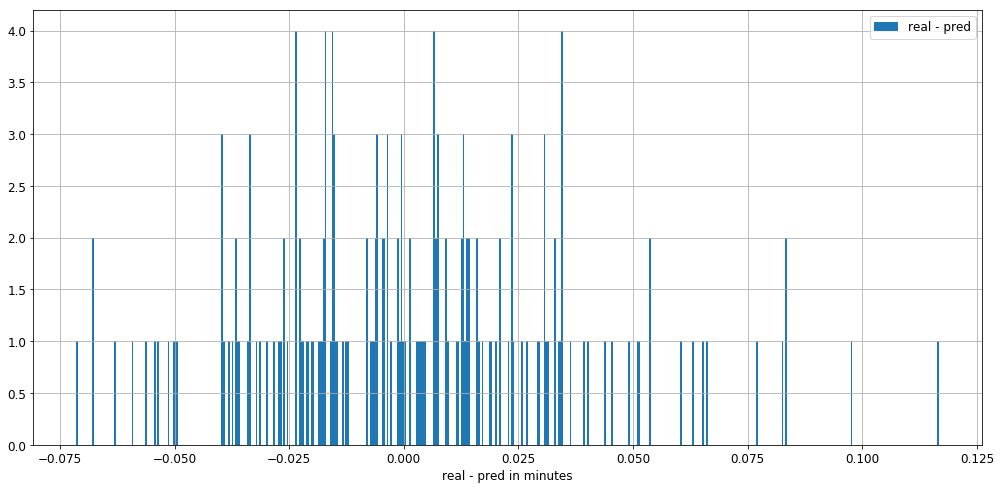

361 records retrieved for link BNL-ATLAS --> INFN-ROMA1 (Data Consolidation).


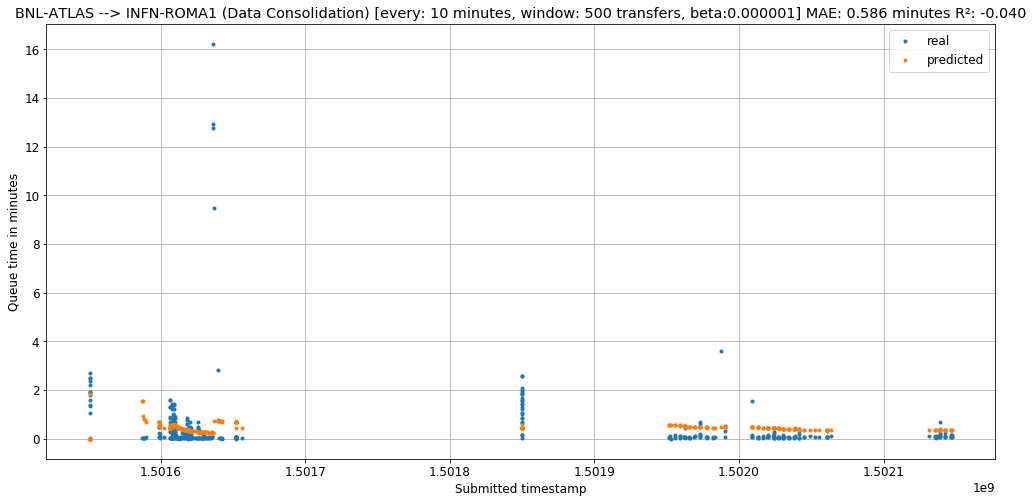

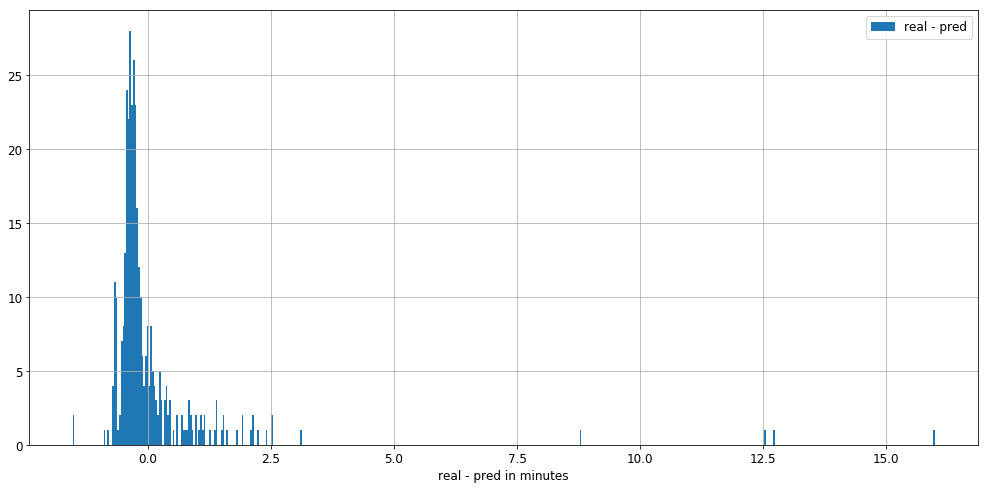

118 records retrieved for link NDGF-T1 --> INFN-ROMA1 (Data Consolidation).


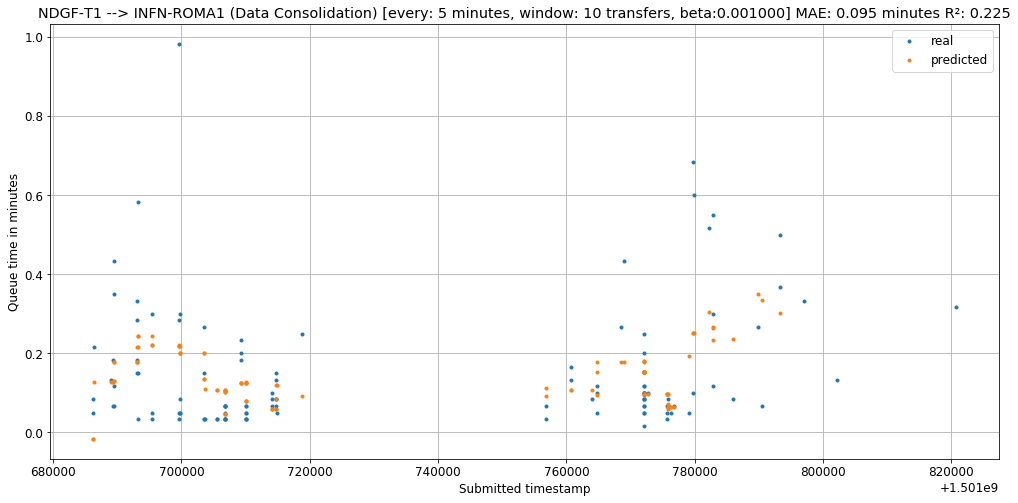

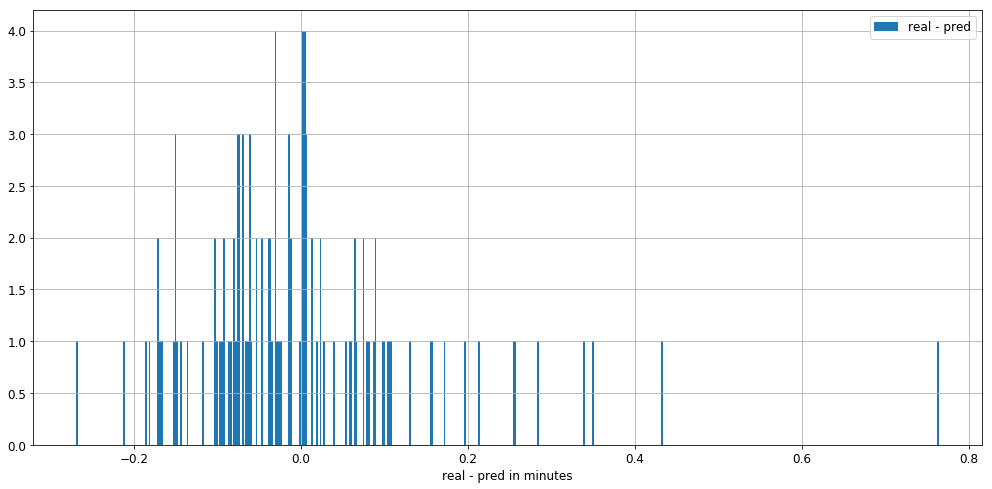

151 records retrieved for link IN2P3-CC --> INFN-ROMA1 (Data Consolidation).


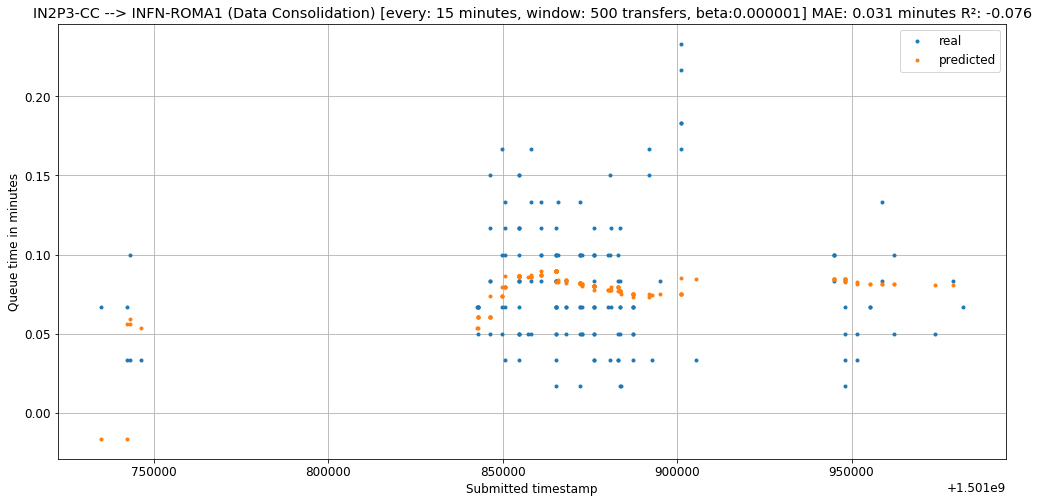

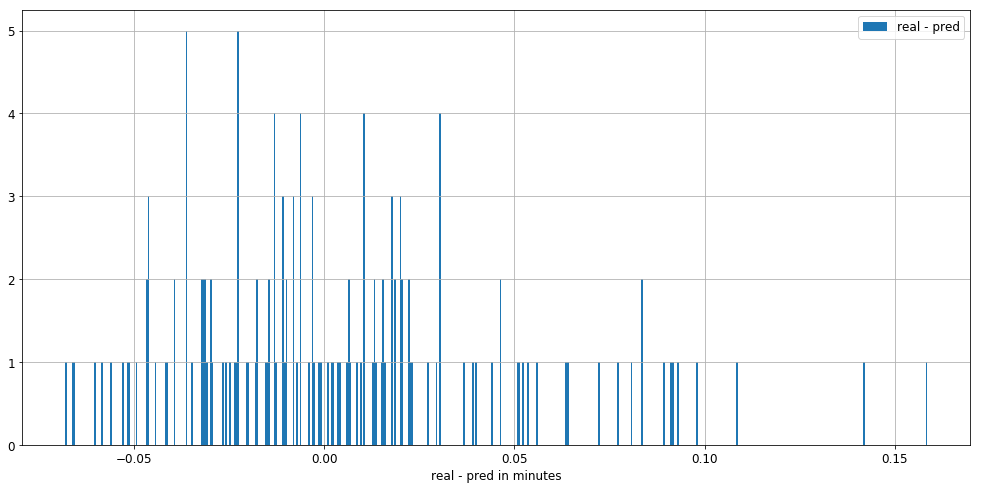

0 records retrieved for link WT2 --> INFN-ROMA1 (Data Consolidation).
No enough data for link WT2 --> INFN-ROMA1 (Data Consolidation)
297900 records retrieved for link CERN-PROD --> CERN-PROD (Data Consolidation).


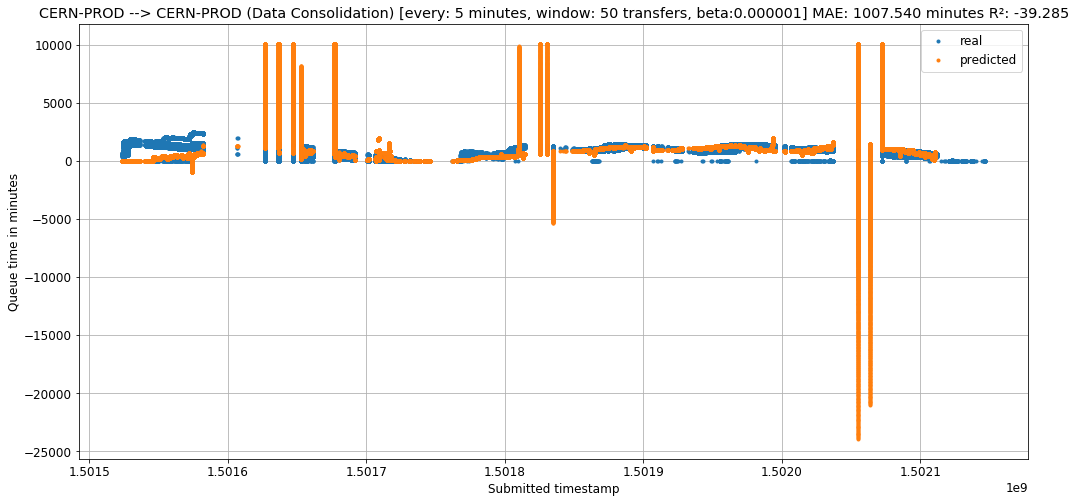

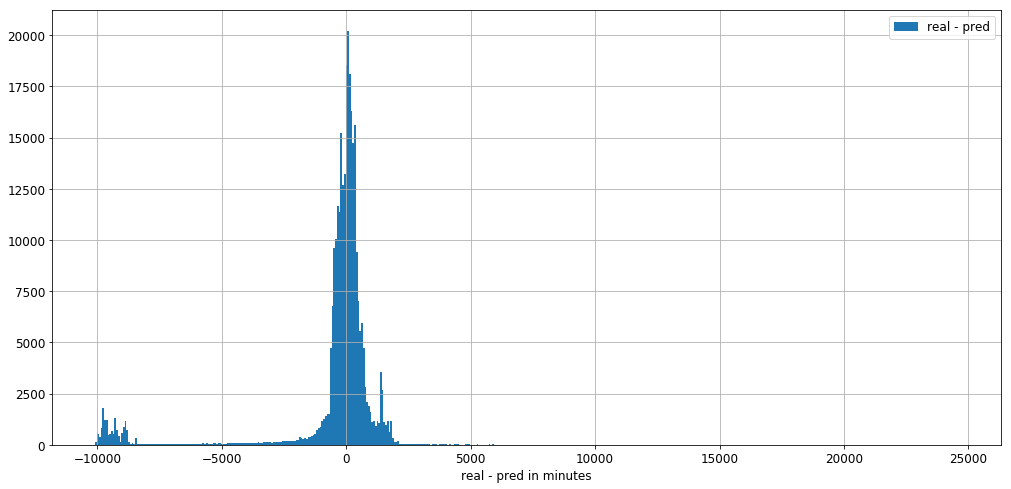

39466 records retrieved for link BNL-ATLAS --> CERN-PROD (Data Consolidation).


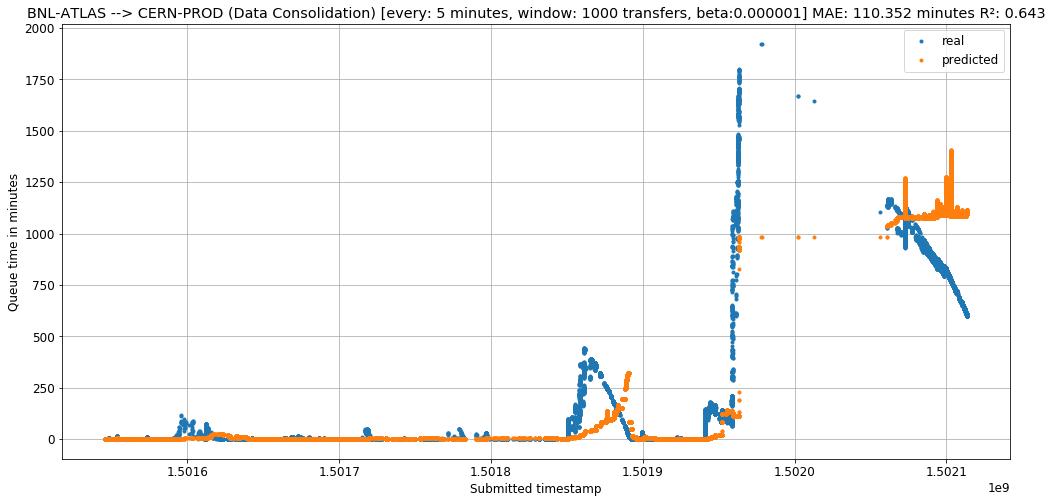

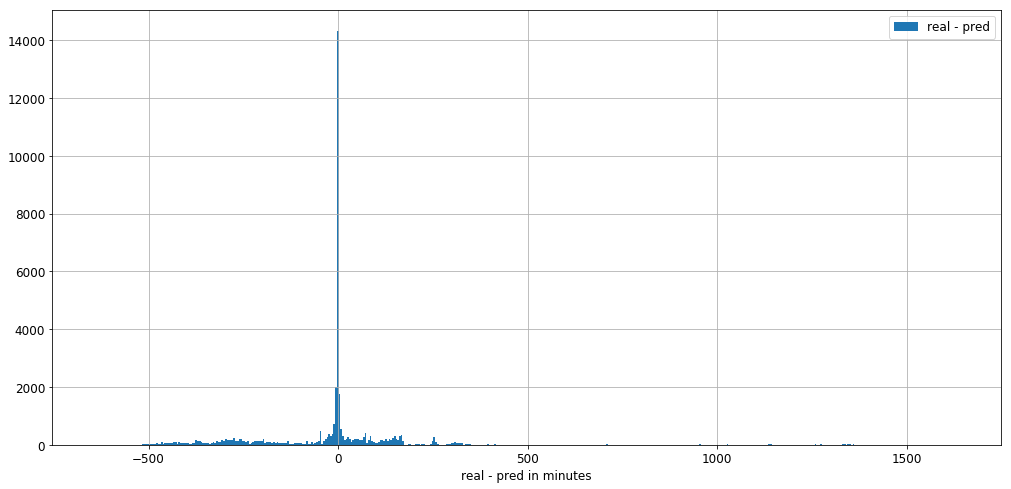

30156 records retrieved for link NDGF-T1 --> CERN-PROD (Data Consolidation).


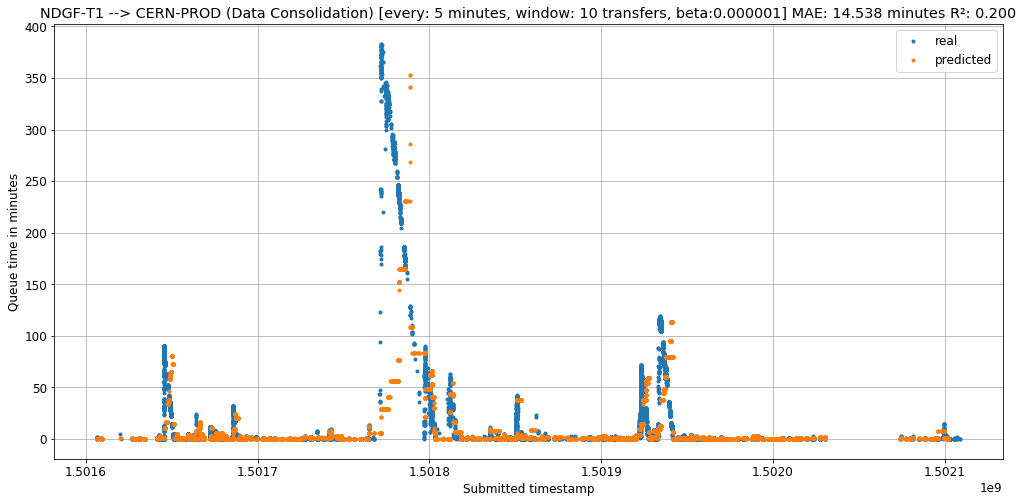

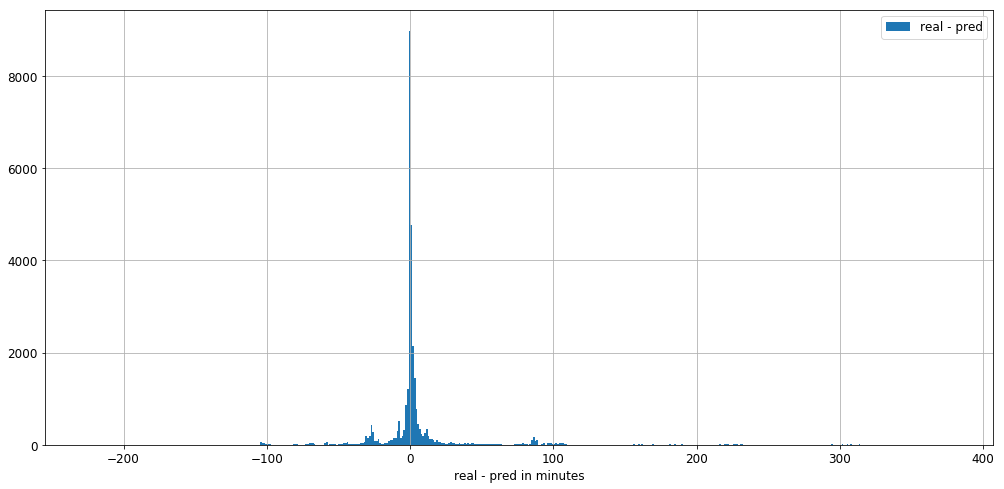

12639 records retrieved for link IN2P3-CC --> CERN-PROD (Data Consolidation).


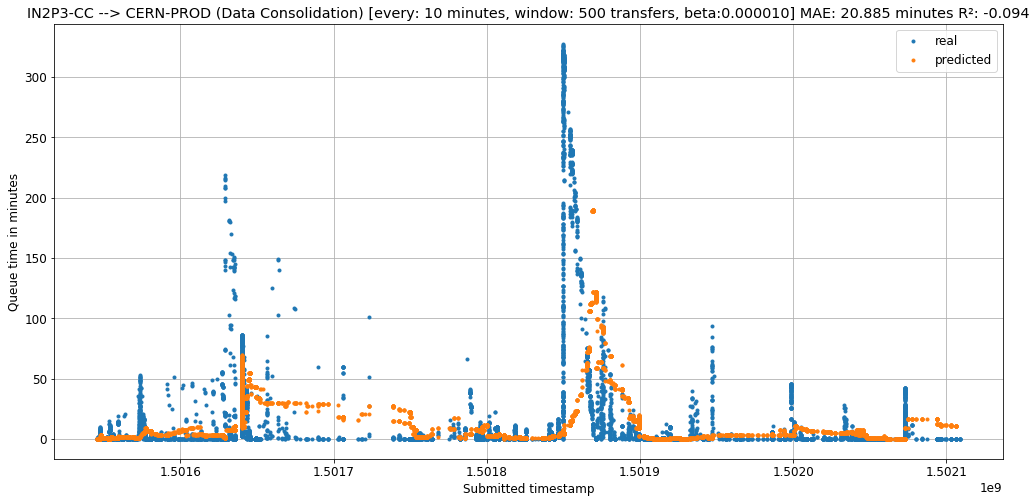

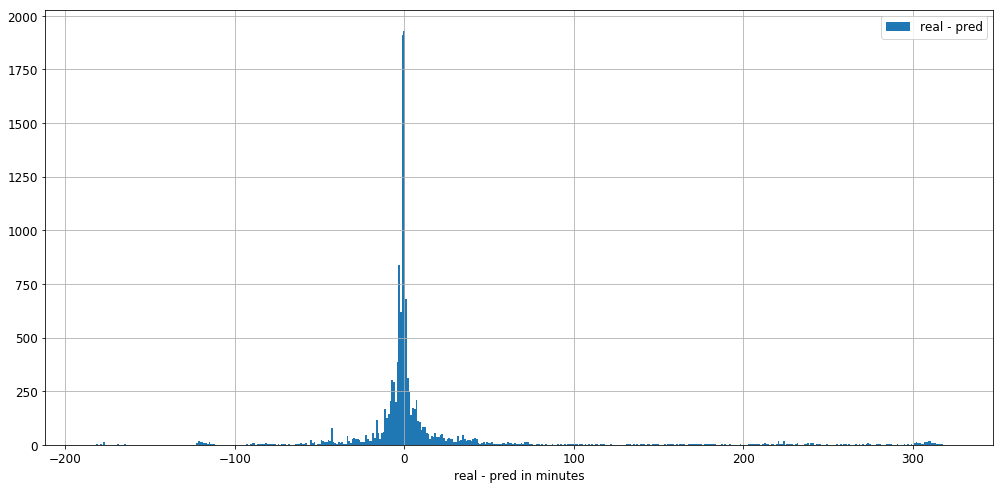

0 records retrieved for link WT2 --> CERN-PROD (Data Consolidation).
No enough data for link WT2 --> CERN-PROD (Data Consolidation)
5472 records retrieved for link CERN-PROD --> AGLT2 (Data Consolidation).


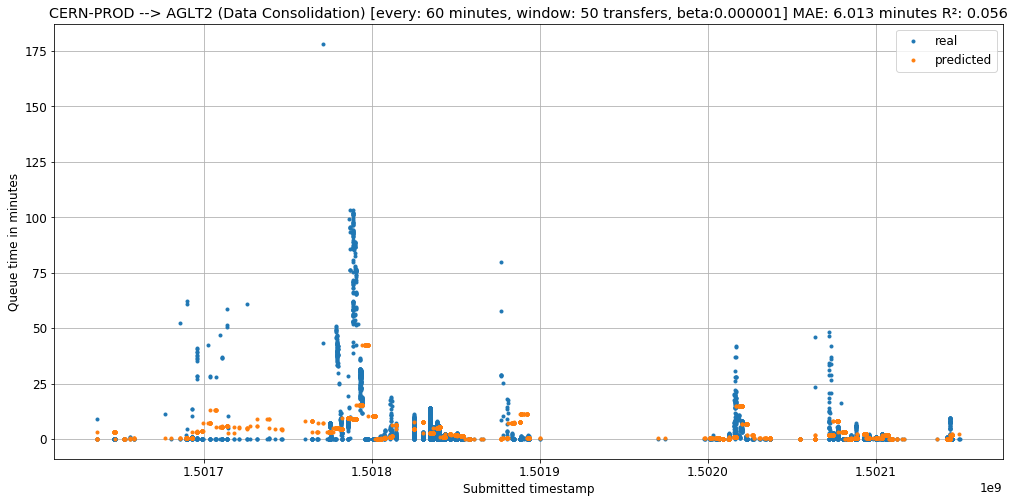

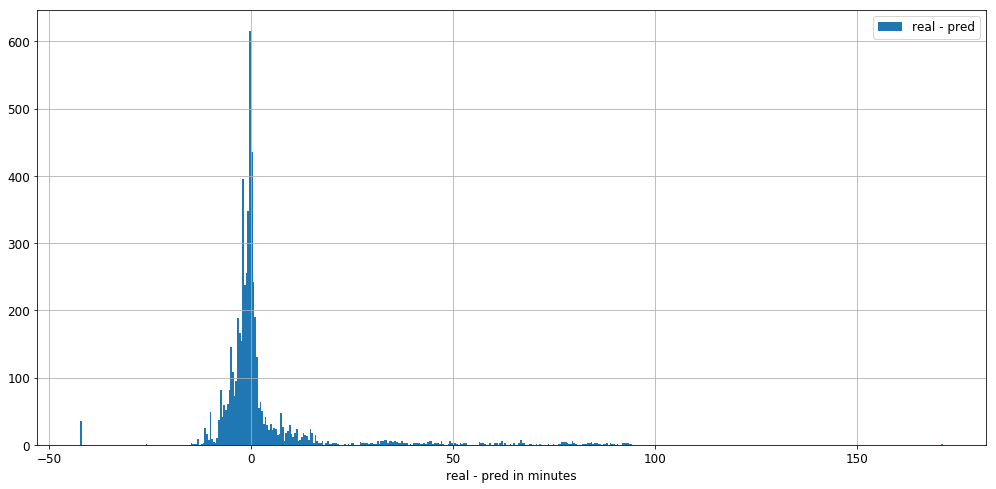

8746 records retrieved for link BNL-ATLAS --> AGLT2 (Data Consolidation).


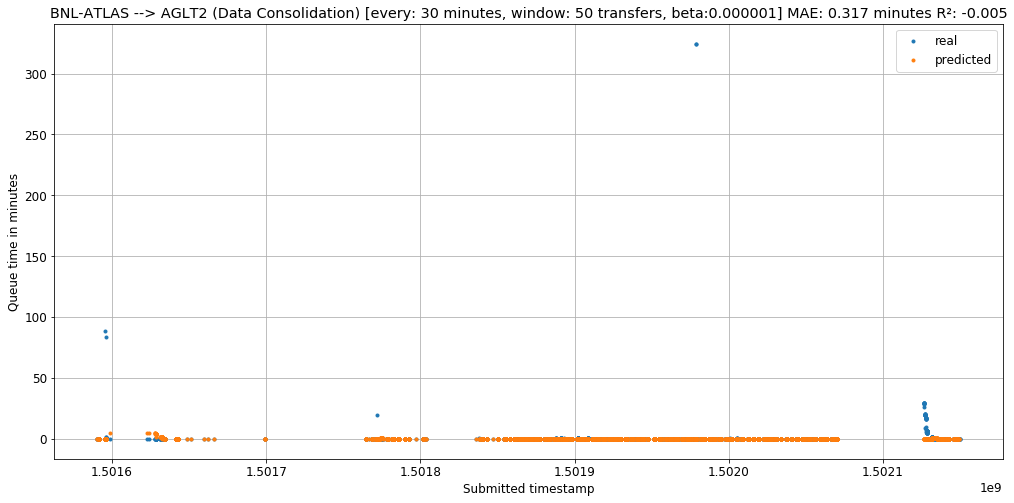

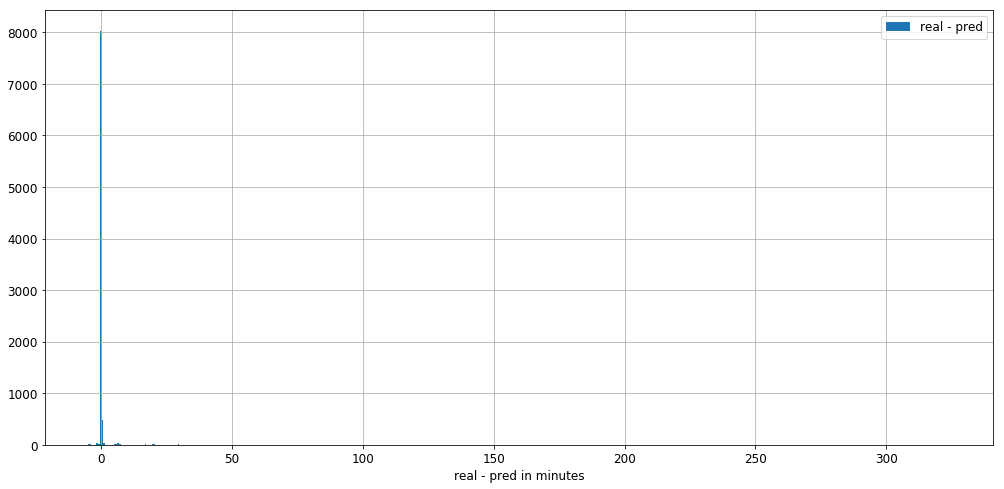

5074 records retrieved for link NDGF-T1 --> AGLT2 (Data Consolidation).


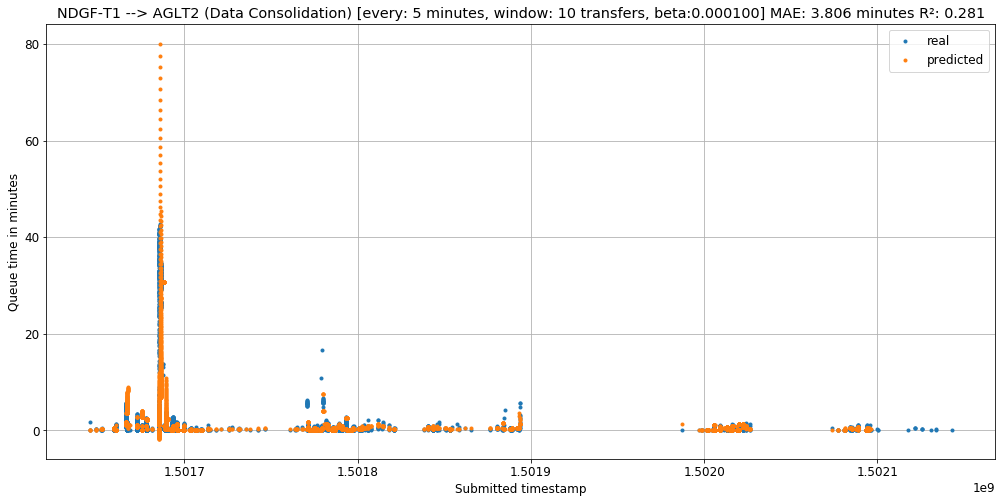

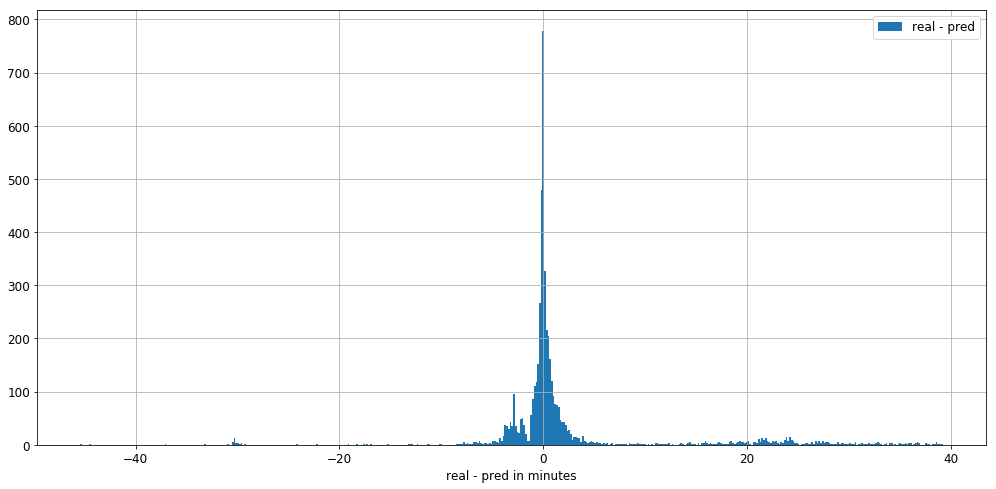

3427 records retrieved for link IN2P3-CC --> AGLT2 (Data Consolidation).


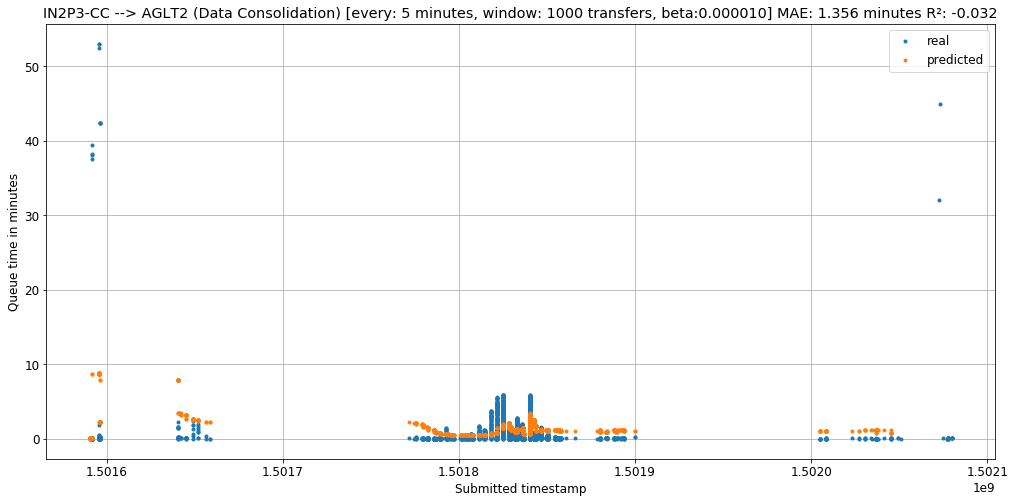

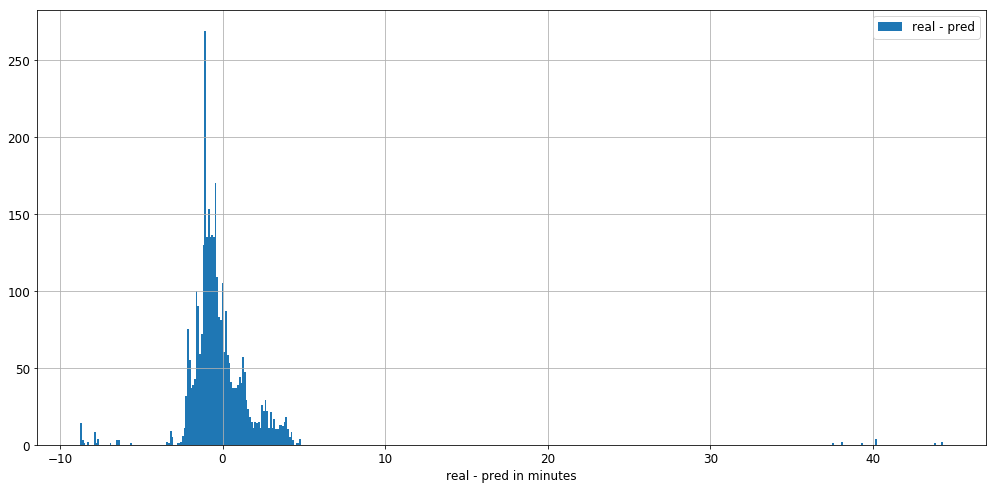

0 records retrieved for link WT2 --> AGLT2 (Data Consolidation).
No enough data for link WT2 --> AGLT2 (Data Consolidation)
0 records retrieved for link CERN-PROD --> RAL-LGC2 (Data Consolidation).
No enough data for link CERN-PROD --> RAL-LGC2 (Data Consolidation)
0 records retrieved for link BNL-ATLAS --> RAL-LGC2 (Data Consolidation).
No enough data for link BNL-ATLAS --> RAL-LGC2 (Data Consolidation)
0 records retrieved for link NDGF-T1 --> RAL-LGC2 (Data Consolidation).
No enough data for link NDGF-T1 --> RAL-LGC2 (Data Consolidation)
0 records retrieved for link IN2P3-CC --> RAL-LGC2 (Data Consolidation).
No enough data for link IN2P3-CC --> RAL-LGC2 (Data Consolidation)
0 records retrieved for link WT2 --> RAL-LGC2 (Data Consolidation).
No enough data for link WT2 --> RAL-LGC2 (Data Consolidation)
15577 records retrieved for link CERN-PROD --> BNL-ATLAS (User Subscriptions).


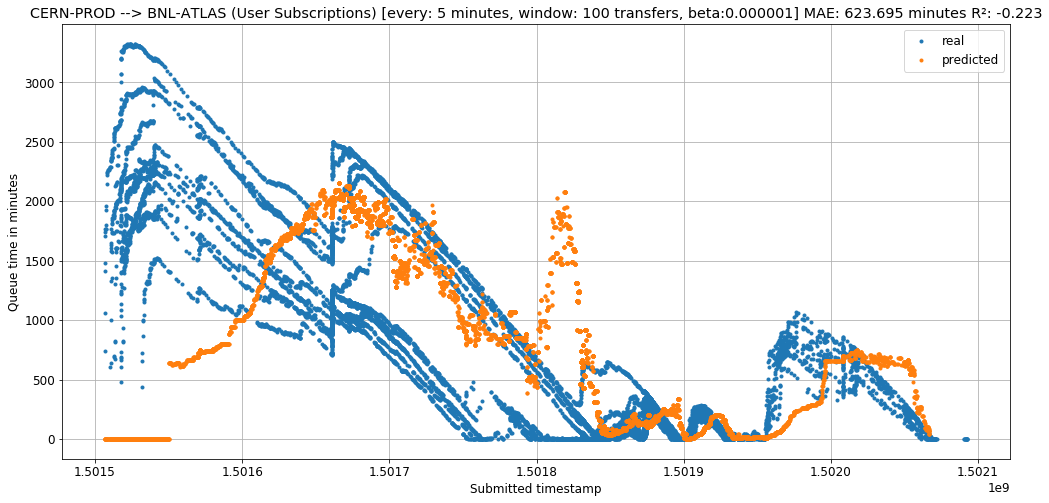

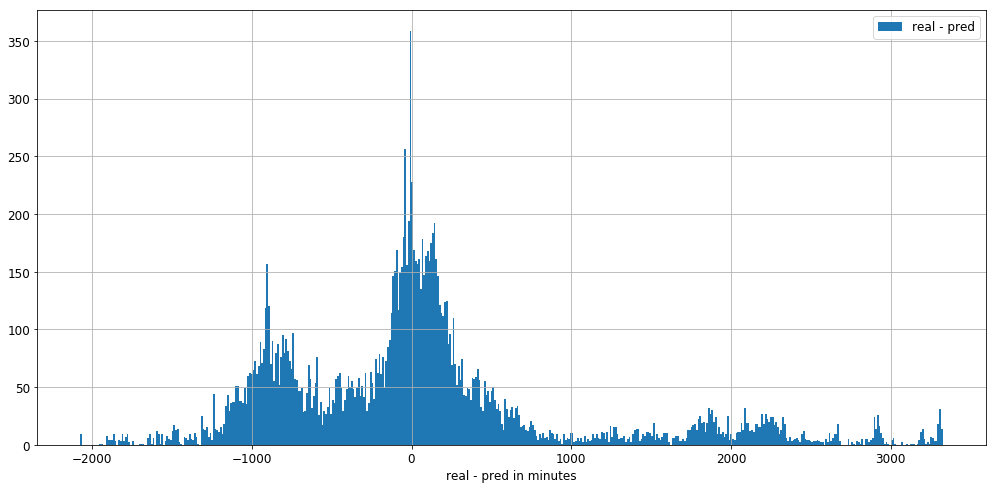

7259 records retrieved for link BNL-ATLAS --> BNL-ATLAS (User Subscriptions).


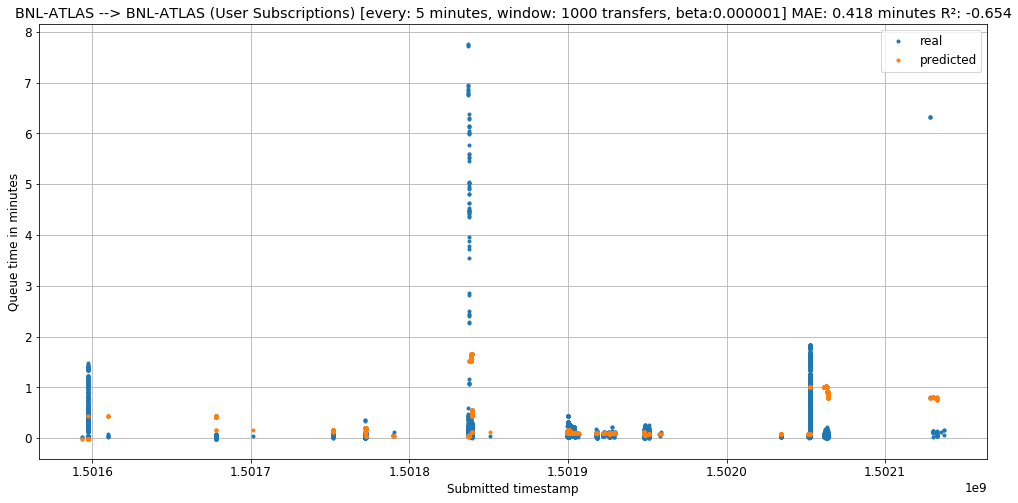

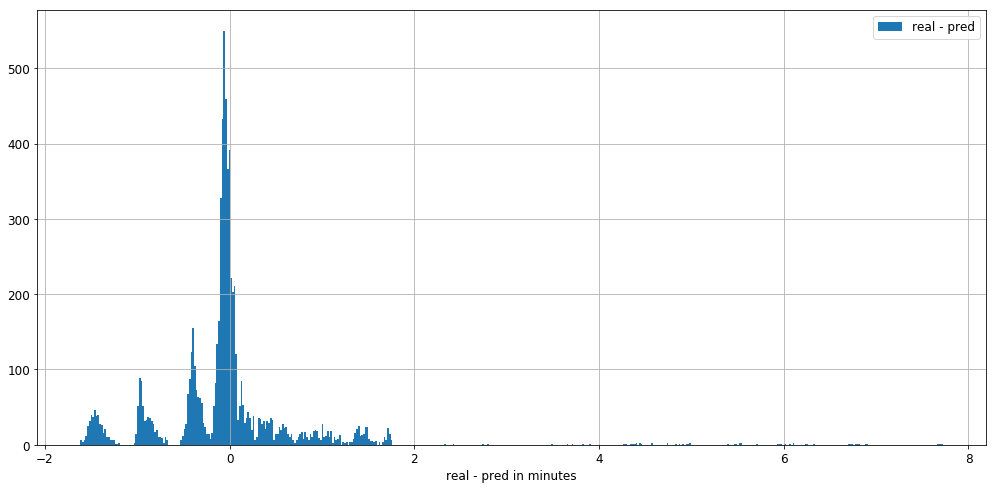

27748 records retrieved for link NDGF-T1 --> BNL-ATLAS (User Subscriptions).


KeyError: 'NDGF-T1__BNL-ATLAS__User Subscriptions'

In [29]:
links = {}
srcs = ['CERN-PROD','BNL-ATLAS','NDGF-T1','IN2P3-CC','WT2']
dsts = ['BNL-ATLAS','INFN-ROMA1','CERN-PROD','AGLT2','RAL-LGC2']
acts = ['Data Consolidation', 'User Subscriptions', 'Production Input', 'Express', 'Production Output']
for a in acts:
    for d in dsts:
        for s in srcs:
            data = get_link_data(s,d,a,'2017-08-01', 7)
            if len(data) < 10:
                print('No enough data for link %s --> %s (%s)' % (s,d,a))
                continue
            max_r2 = -100
            #mae_limit = 1000000
            for every in [5,10,15,30,60]:
                for window in [10,50,100,500,1000]:
                    for beta in [0.000001,0.00001,0.0001,0.001]:
                        x,y,y_real = make_prediction(data, window, every, beta)
                        try:
                            if r2(y_real,y) > max_r2:#mae(y,y_real) < min_mae:
                                links[s+'__'+d+'__'+a] = (x,y,y_real,every,window,beta)
                                max_r2 = r2(y_real,y)
                                #min_mae = mae(y,y_real)
                            #if mae(y_real,y) > mae_limit:
                            #    continue
                        except ValueError:
                            continue
                
            x,y,y_real,every,window,beta = links[s+'__'+d+'__'+a]
            plt.title('%s --> %s (%s) [every: %d minutes, window: %d transfers, beta:%f] MAE: %0.3f minutes R²: %0.3f'%
                      (s,d,a,every,window,beta,mae(y_real,y)/60,r2(y_real,y)))
            plt.plot(data.SUBMITTED.values,data.Q_TIME.values/60,'.', label='real')
            plt.plot(x,y/60,'.', label='predicted')
            #lt.yscale('log')
            #plt.xscale('log')
            plt.xlabel('Submitted timestamp')
            plt.ylabel('Queue time in minutes')
            fig = plt.gcf()
            fig.set_size_inches(17, 8)
            plt.legend()
            plt.grid()
            plt.show()

            plt.hist(y_real/60 - y/60, label='real - pred',bins=500)
            #lt.yscale('log')
            #plt.xscale('log')
            plt.xlabel('real - pred in minutes')
            fig = plt.gcf()
            fig.set_size_inches(17, 8)
            plt.legend()
            plt.grid()
            plt.show()